# 1. Libraries and Data
In this first section I import the data into the work space, and give it the necessary format to be used during the stochastic modeling process.

In [3]:
# Libraries
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import matplotlib as mlp
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import os
%load_ext autoreload
%autoreload 2
import stochastic_modeling as stc
import pmdarima as pm

mlp.style.use('seaborn-notebook')
sns.set(font_scale=1.1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
full_rates = pd.read_csv('historico_tasas_python.csv',index_col=0).astype(
    {'Fecha':'datetime64[ns]'}
).set_index('Fecha', drop=True)
full_rates

,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,DTF,IPC Anual,IPC Mensual,FED,UVR,...,IBC,USURA,TRM,DEV. TRM,LIBOR,SOFR,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
Fecha,,,,,,,,,,,,,,,,,,,,,
1999-01-01,0.26,NaN,NaN,NaN,NaN,0.3433,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1542.11,0.192126,NaN,NaN,NaN,NaN,271.65,0.110907
1999-01-02,0.26,NaN,NaN,NaN,NaN,0.3433,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1542.11,0.192126,NaN,NaN,NaN,NaN,271.65,0.110907
1999-01-03,0.26,NaN,NaN,NaN,NaN,0.3433,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1542.11,0.182300,NaN,NaN,NaN,NaN,271.65,0.110680
1999-01-04,0.26,NaN,NaN,NaN,NaN,0.3406,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1542.11,0.182300,NaN,NaN,NaN,NaN,271.65,0.110680
1999-01-05,0.26,NaN,NaN,NaN,NaN,0.3406,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1545.11,0.184601,NaN,NaN,NaN,NaN,271.85,0.111497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-05,0.02,0.01980,0.02039,0.02430,0.03000,0.0204,0.0444,0.0045,0.0025,286.3298,...,0.1708,0.25620,3786.05,-0.024666,0.001551,0.0005,24.2507,-0.014644,629.65,0.040916
2021-10-06,0.02,0.01976,0.02060,0.02456,0.03043,0.0204,0.0451,0.0038,0.0025,286.3726,...,0.1708,0.25620,3796.30,-0.012345,0.001561,0.0005,24.2507,-0.014536,629.12,0.041710
2021-10-07,0.02,0.01975,0.02048,0.02460,0.03038,0.0204,0.0451,0.0038,0.0025,286.4155,...,0.1708,0.25620,3788.03,-0.010123,0.001559,0.0005,24.2507,-0.014239,630.13,0.040351


In [5]:
monthly_rates = full_rates.groupby(pd.Grouper(freq='M')).last()

In [6]:
def jump_class(x):
    if x>=5: return 5
    elif x==0: return 1
    else: return x
tibr = full_rates.loc['2000-01-01':,'TIBR']
saltos_tibr = tibr.loc[tibr/tibr.shift(1)!=1].to_frame().reset_index()
dc = saltos_tibr['Fecha']
shift_dc = dc.shift(1)
saltos_tibr['delta_t'] = 12*(dc.dt.year-shift_dc.dt.year)+dc.dt.month-\
    shift_dc.dt.month
saltos_tibr = saltos_tibr.loc[saltos_tibr['Fecha']>='2011-01-01']
saltos_tibr['clase'] = saltos_tibr['delta_t'].apply(jump_class)
lmbda = saltos_tibr['clase'].mean()

In [7]:
tibr['2011-01-01':]

Fecha
2011-01-01    0.03
2011-01-02    0.03
2011-01-03    0.03
2011-01-04    0.03
2011-01-05    0.03
              ... 
2021-10-05    0.02
2021-10-06    0.02
2021-10-07    0.02
2021-10-08    0.02
2021-10-09    0.02
Name: TIBR, Length: 3935, dtype: float64

In [8]:
saltos_tibr['clase'].mean()

1.9230769230769231

<AxesSubplot:xlabel='Fecha'>

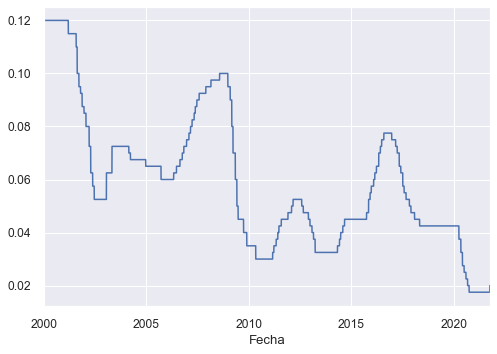

In [9]:
tibr.plot()

In [12]:
adfuller(transformed)

(-2.4938316915317267,
 0.11698236357031044,
 9,
 42,
 {'1%': -3.596635636000432,
  '5%': -2.933297331821618,
  '10%': -2.6049909750566895},
 -94.52046534373505)

In [187]:
transformed = -np.log(0.15/saltos_tibr['TIBR']-1)
model = ARIMA(transformed.values, order=(2,0,4))
model_fit = model.fit()
model_fit.summary()

C:\Users\PERSONAL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   52
Model:                 ARIMA(2, 0, 4)   Log Likelihood                  69.993
Date:                Fri, 05 Nov 2021   AIC                           -123.987
Time:                        11:05:47   BIC                           -108.377
Sample:                             0   HQIC                          -118.002
                                 - 52                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8846      0.227     -3.905      0.000      -1.329      -0.441
ar.L1          1.7678      0.189      9.362      0.000       1.398       2.138
ar.L2         -0.8233      0.192     -4.295      0.000      -1.199      -0.448
ma.L1         -0.4639      0.741     -0.626      0.532      -1.917       0.989
ma.L2          0.0943      0.468      0.201      0.840      -0.823       1.012
ma.L3          0.3929      0.747      0.526      0.599      -1.070       1.856
ma.L4          0.3705      0.602      0.615      0.538      -0.810       1.551
sigma2         0.0032      0.004      0.842      0.400      -0.004       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.18
Prob(Q):                              0.92   Prob(JB):                         0.20
Heteroskedasticity (H):               1.19   Skew:                             0.49
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

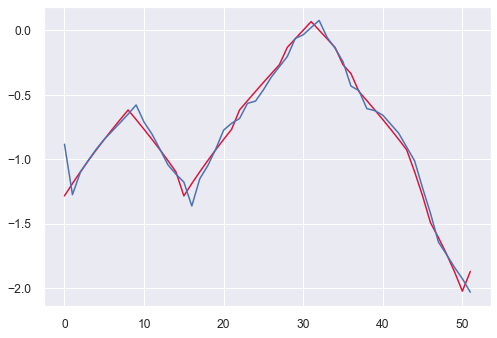

In [188]:
plt.plot(transformed.values, color='crimson')
plt.plot(model_fit.fittedvalues)

In [189]:
from sklearn.metrics import r2_score
r2_score(transformed.values, model_fit.fittedvalues)

0.9734663806282864

In [176]:
model_fit.resid.std()

0.08132546759955517

In [180]:
model_fit.resid.std()

0.08132546759955517

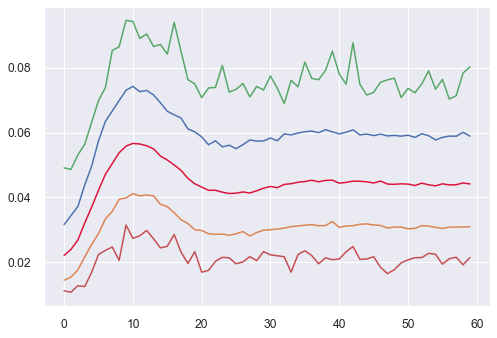

In [190]:
result = (model_fit.forecast(60)).reshape(60,1)+np.random.normal(
    scale = model_fit.resid.std()*np.sqrt(12),
    size = (60, 1000))
result = 0.15/(1+np.exp(-result))
mean = result.mean(axis=1)
mx = result.max(axis=1)
mn = result.min(axis=1)
ps = np.percentile(result, (5, 95), axis=1)
plt.plot(ps[1])
plt.plot(ps[0])
plt.plot(mean, color='crimson')
plt.plot(mx)
plt.plot(mn)

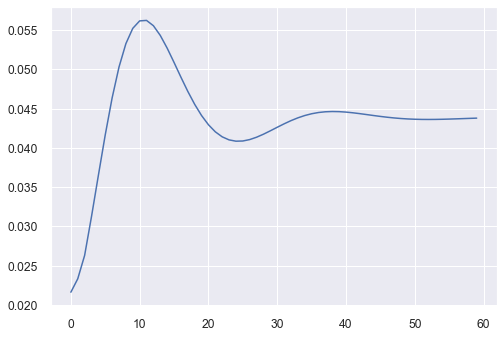

In [191]:
plt.plot(0.15/(1+np.exp(-model_fit.forecast(60))))
#model_fit.forecast(60)

In [192]:
transformed.shape

(52,)

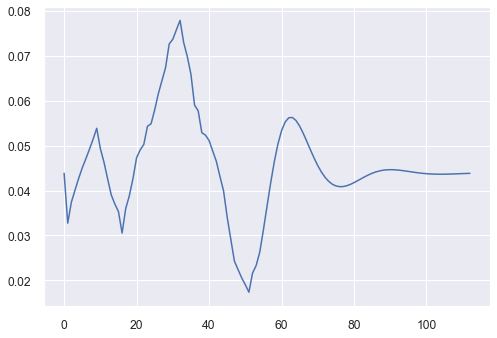

In [195]:
plt.plot(0.15/(1+np.exp(-model_fit.predict(0,112))))

In [196]:
row_index

array([[ 5,  0,  1, ...,  3,  0,  1],
       [ 7,  2,  1, ..., 13,  5,  3],
       [ 7,  6,  2, ..., 16,  6,  6],
       ...,
       [57, 59, 58, ..., 57, 58, 58],
       [57, 59, 58, ..., 57, 58, 58],
       [57, 59, 58, ..., 57, 58, 58]])

In [208]:
row_index = (0-np.log(np.random.uniform(size=(60,1000)))/0.41).round(0).cumsum(axis=0)
row_index = np.where(row_index>=60, np.NaN,row_index)
test_df = pd.DataFrame(row_index)
row_index = test_df.fillna(method='ffill').values.astype(int)
final = np.zeros((60,1000))

for i in range(1000):
    final[:,i] = result[row_index[:,i],i]
final = (final*400).round(0)/400

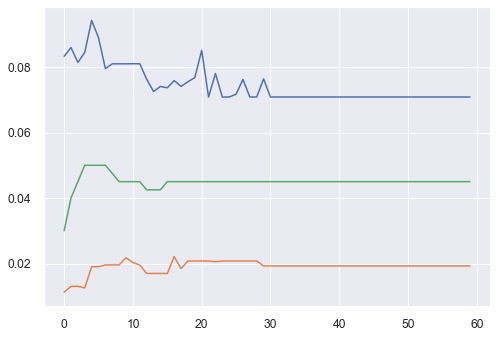

In [210]:
plt.plot(range(60),final.max(axis=1))
plt.plot(range(60),final.min(axis=1))
plt.plot(range(60),(final.mean(axis=1)*400).round(0)/400)

In [50]:
test[1,[3,6,3,32]]

array([-0.07989478,  0.08855019, -0.07989478,  0.00547739])

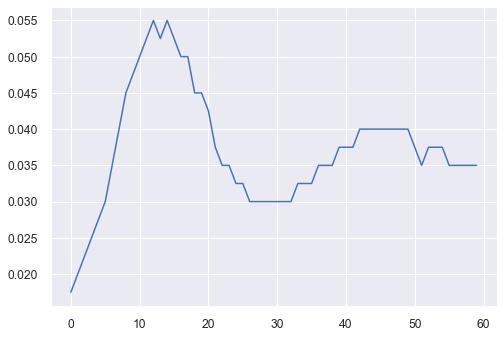

In [51]:
test = ((model_fit.forecast(60)).reshape(60,1)+np.random.normal(
    loc = 0,
    scale = model_fit.resid.std(),size=(60, 1000)))
test = (0.15/(1+np.exp(-test)))
plt.plot(range(60),(400*test.min(axis=1)).round(0)/400)

In [52]:
test[[3,5,2],[45,52, 16]]

array([0.03251531, 0.03687043, 0.02654595])

In [53]:
(np.random.uniform(0,5,size=100)*4).round(0)/4

array([2.75, 4.  , 3.  , 4.75, 4.5 , 4.5 , 1.75, 1.  , 0.25, 1.75, 1.75,
       3.  , 2.5 , 2.  , 1.75, 1.5 , 2.  , 1.75, 4.  , 4.25, 3.75, 4.  ,
       4.75, 1.  , 3.  , 2.5 , 3.75, 1.25, 0.  , 0.5 , 1.5 , 0.5 , 2.75,
       0.75, 2.75, 4.25, 4.5 , 3.  , 4.25, 2.  , 5.  , 0.75, 4.5 , 2.75,
       0.25, 0.25, 3.  , 3.25, 3.75, 3.  , 4.75, 3.75, 1.5 , 4.  , 5.  ,
       3.75, 3.  , 2.5 , 2.25, 2.  , 0.5 , 0.  , 3.25, 0.5 , 4.  , 4.25,
       1.  , 4.5 , 3.25, 4.75, 3.75, 4.75, 4.25, 3.25, 3.  , 2.25, 4.25,
       4.75, 1.5 , 1.25, 1.  , 4.5 , 5.  , 1.75, 5.  , 2.25, 5.  , 0.75,
       2.  , 3.5 , 4.5 , 3.25, 0.  , 2.25, 1.  , 4.  , 4.25, 2.5 , 0.  ,
       4.25])

In [47]:
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'eviews_tibr_forecast.xlsx',
 'historico_tasas_python.csv',
 'README.md',
 'Stochastic Rates Modeling.ipynb',
 'stochastic_modeling.py',
 '__pycache__']

In [19]:
1350000*53.13

71725500.0

In [75]:
t/(0.15-t)

-1.6

In [93]:
0.15/t

0.37499999999999994

In [94]:
t = .04
-np.log(0.15/t-1)#, np.log(t/(0.15-t))

-1.0116009116784799

In [111]:
trm_gbm = stc.GBMRateSeries(trm,Np=10000, Nt=60, T=60, u_bound=9000)

(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:>)

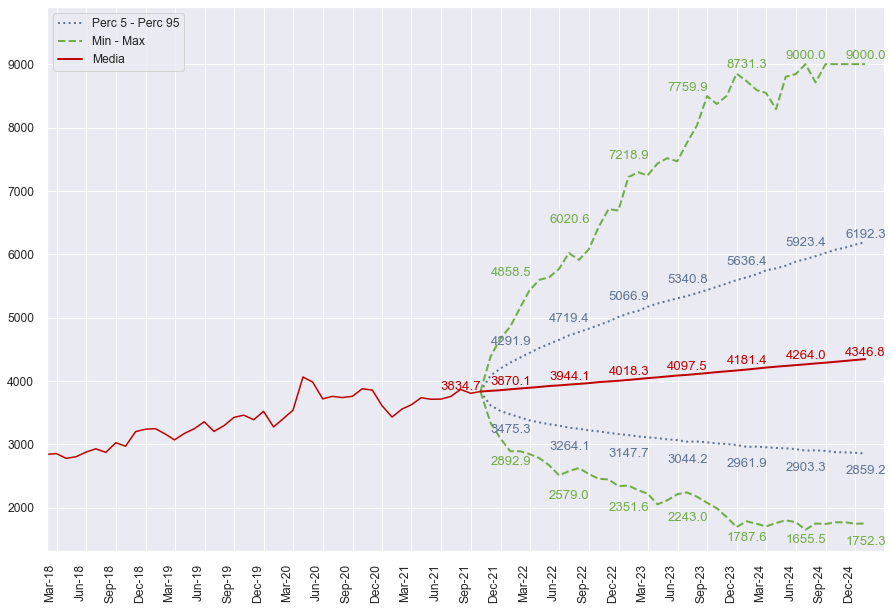

In [112]:
trm_gbm.plot_full_series('2018-01-01','2024-12-31')

(<Figure size 1800x720 with 1 Axes>, <AxesSubplot:>)

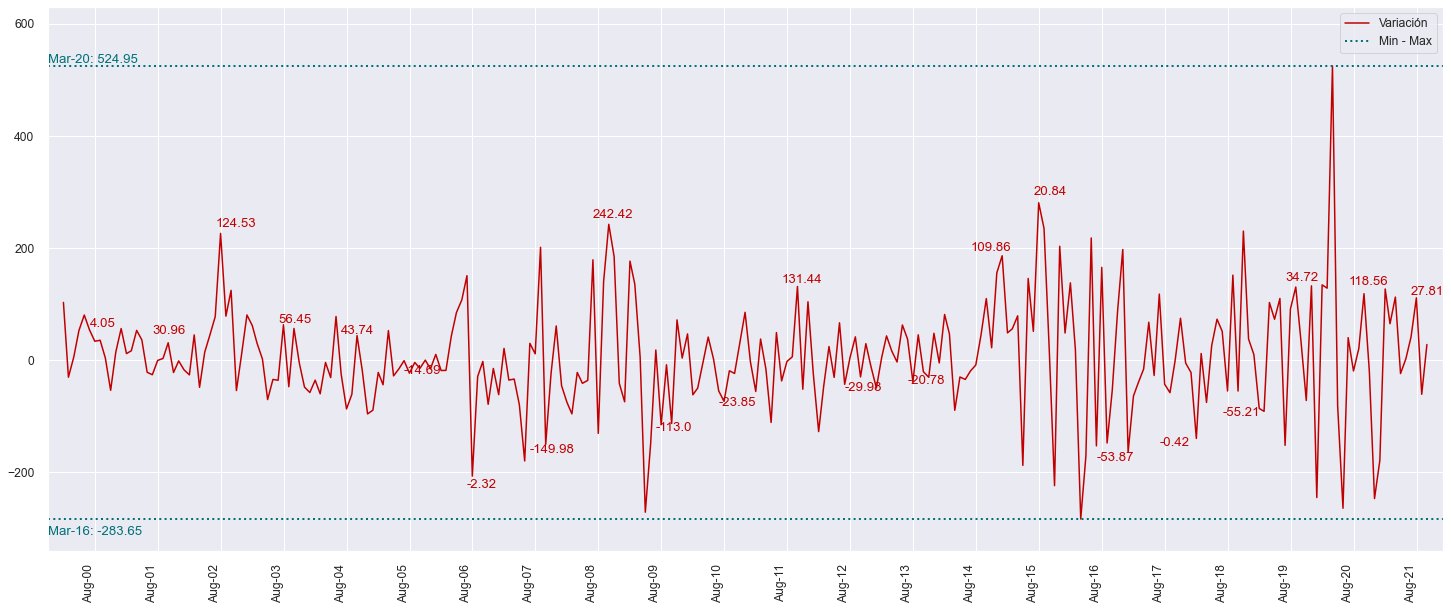

In [113]:
trm_gbm.plot_historic_variation(month_space=3, figsize=(25,10))

(<Figure size 1800x720 with 1 Axes>, <AxesSubplot:>)

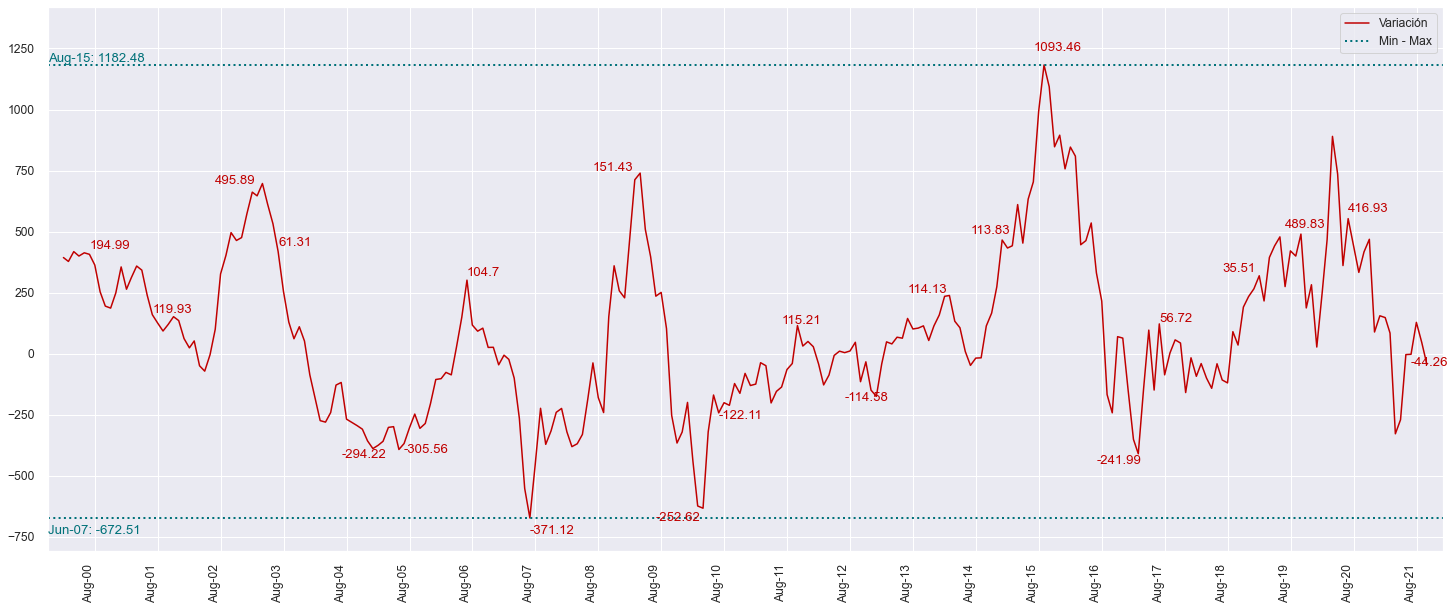

In [99]:
trm_gbm.plot_historic_variation(month_space=3, figsize=(25,10), ref=12)

(<Figure size 1440x720 with 1 Axes>, <AxesSubplot:>)

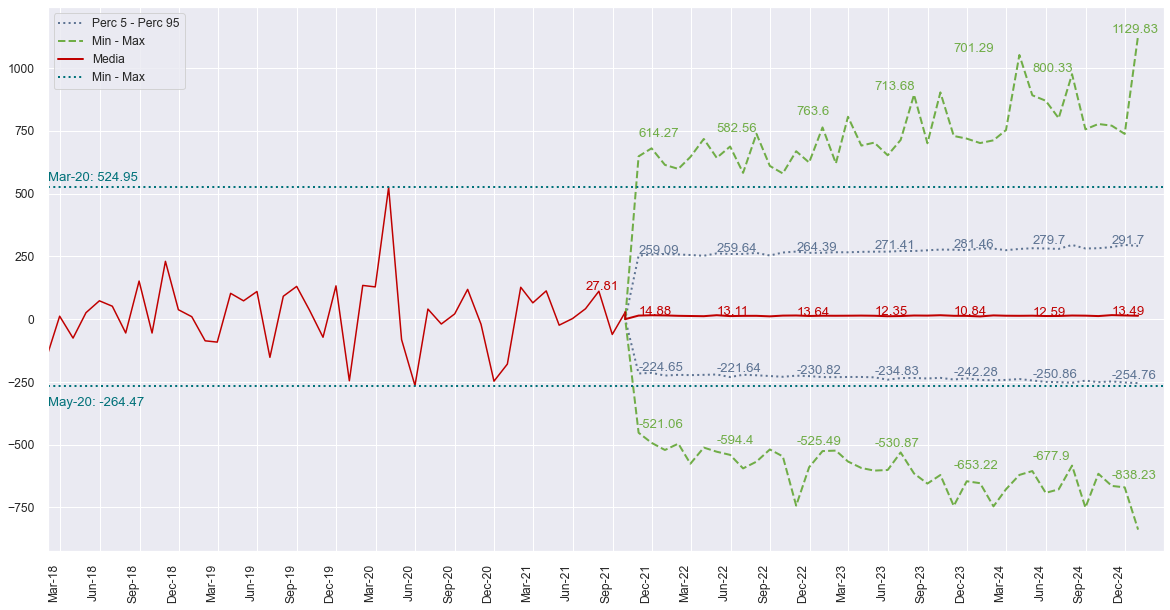

In [100]:
trm_gbm.plot_full_variations('2018-01-01', '2024-12-31', figsize=(20,10), dec=2)

In [101]:
np.log(trm/trm.shift(1)).agg(['min','mean','max', np.std])

min    -0.112046
mean    0.003253
max     0.138280
std     0.037212
Name: TRM, dtype: float64

(<Figure size 1440x720 with 1 Axes>, <AxesSubplot:>)

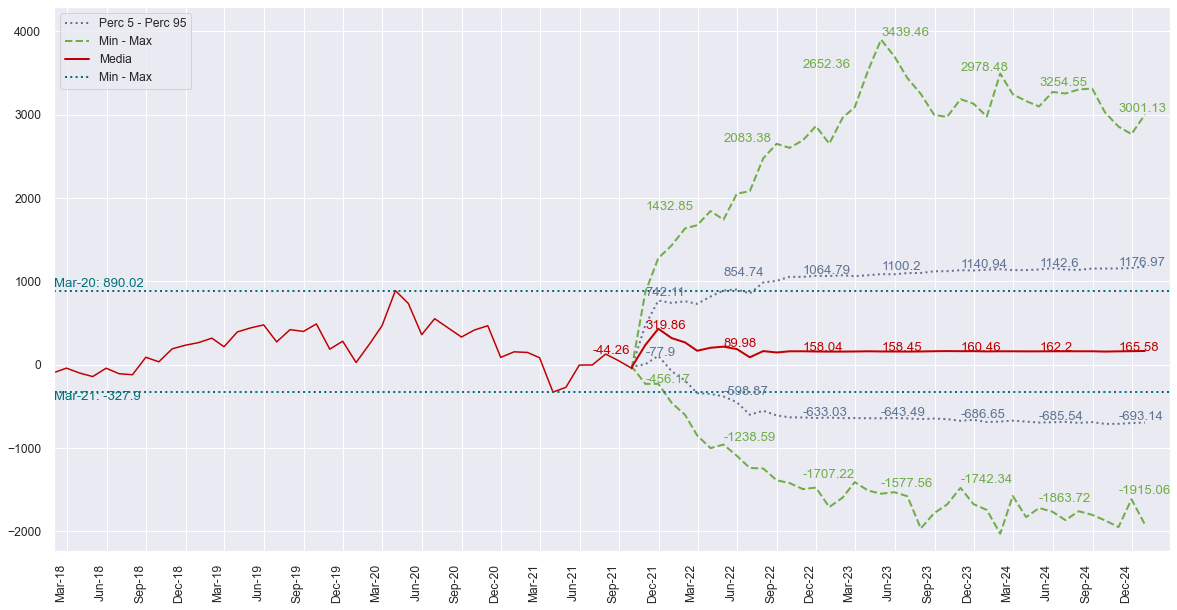

In [102]:
trm_gbm.plot_full_variations('2018-01-01', '2024-12-31', figsize=(20,10), ref=12, dec=2)

In [84]:
np.log(trm/trm.shift(1)).agg(['min','max','mean', 'std'])

min    -0.112046
max     0.138280
mean    0.003253
std     0.037212
Name: TRM, dtype: float64

<AxesSubplot:>

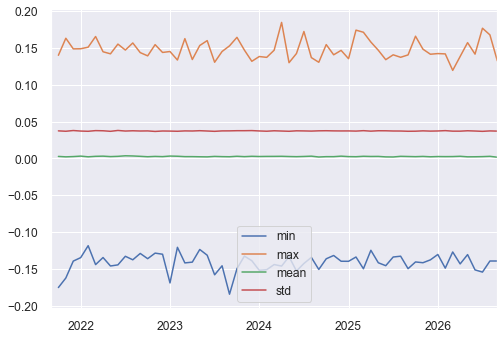

In [85]:
np.log(trm_gbm.sim_df/trm_gbm.sim_df.shift(1)).agg(['min','max','mean', 'std'], axis=1).plot()

In [29]:
trm_gbm.sim_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2021-09-30,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,...,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000
2021-10-31,3940.241312,4069.381346,4050.744576,3939.770528,3884.992783,3922.566265,4074.092099,3797.667502,3690.605862,3945.590183,...,4081.431614,4076.453331,3662.485604,3767.312146,3655.993802,3643.874234,3852.540147,3926.316059,3798.255342,3503.276802
2021-11-30,4060.906772,4089.467601,3990.520387,4023.919336,4063.333711,3791.887564,4282.509623,3864.659388,3639.010974,3841.209825,...,4129.805158,3684.727352,3616.743394,3962.418477,3595.223271,3516.173184,4141.682933,3977.489818,3655.192443,3356.545723
2021-12-31,4119.404120,4197.452498,4036.856334,4435.534673,4062.934826,4032.896183,4658.479319,3883.095769,3689.358910,3906.391975,...,4289.643444,3863.267961,3506.544791,3870.292763,3666.967157,3536.534898,4176.740849,3902.446840,3601.992100,3415.197865
2022-01-31,4319.663714,4233.638053,3997.748096,4277.810937,3991.751754,3897.599947,4888.489450,3787.250897,3839.789605,3911.010273,...,4091.604533,4046.768689,3472.424477,3792.240536,3730.751701,3512.575984,4088.297827,3903.292484,3356.926181,3288.904195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-05-31,4304.488250,7160.871212,4973.192113,7425.892950,3746.632631,6567.132179,5409.269880,3458.291134,6361.352911,3388.971761,...,5619.933470,5053.036726,4715.661258,3580.794113,5157.605966,4606.155815,4503.768542,4017.757399,2653.594811,4998.945558
2026-06-30,4623.074875,7283.787118,4772.209004,7354.357415,3654.892807,6562.986786,5326.037923,3424.596300,6946.532695,3538.176100,...,5574.645181,5298.686087,4990.384120,3755.682969,5030.601331,4761.011172,4485.215075,4178.041410,2860.170378,5067.988079
2026-07-31,4859.641580,7230.359823,4853.827854,7290.345204,3849.874638,6930.527156,5047.914873,3403.311501,6981.579608,3630.619456,...,5505.406881,5090.132993,4755.305915,3905.733322,5225.921505,4622.339981,4454.215958,4272.878522,2871.897988,5136.347241
2026-08-31,4789.665389,7518.462457,4857.375215,7744.461104,3969.403232,6976.767490,4811.352822,3577.107680,7008.167987,3581.501467,...,5559.800051,4856.721459,4781.456867,3881.135071,5266.409482,4506.979256,4452.413775,4418.893088,3002.477270,5392.070370


In [40]:
trm_gbm.sim_df.loc[:,0].where(trm_gbm.sim_df.loc[:,0]<=9000,9000)

2021-09-30    3834.680000
2021-10-31    3940.241312
2021-11-30    4060.906772
2021-12-31    4119.404120
2022-01-31    4319.663714
                 ...     
2026-05-31    4304.488250
2026-06-30    4623.074875
2026-07-31    4859.641580
2026-08-31    4789.665389
2026-09-30    4881.914361
Name: 0, Length: 61, dtype: float64

In [41]:
trm_gbm.sim_df.apply(lambda x: x.where(x<=9000, 9000))


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2021-09-30,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,...,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000
2021-10-31,3940.241312,4069.381346,4050.744576,3939.770528,3884.992783,3922.566265,4074.092099,3797.667502,3690.605862,3945.590183,...,4081.431614,4076.453331,3662.485604,3767.312146,3655.993802,3643.874234,3852.540147,3926.316059,3798.255342,3503.276802
2021-11-30,4060.906772,4089.467601,3990.520387,4023.919336,4063.333711,3791.887564,4282.509623,3864.659388,3639.010974,3841.209825,...,4129.805158,3684.727352,3616.743394,3962.418477,3595.223271,3516.173184,4141.682933,3977.489818,3655.192443,3356.545723
2021-12-31,4119.404120,4197.452498,4036.856334,4435.534673,4062.934826,4032.896183,4658.479319,3883.095769,3689.358910,3906.391975,...,4289.643444,3863.267961,3506.544791,3870.292763,3666.967157,3536.534898,4176.740849,3902.446840,3601.992100,3415.197865
2022-01-31,4319.663714,4233.638053,3997.748096,4277.810937,3991.751754,3897.599947,4888.489450,3787.250897,3839.789605,3911.010273,...,4091.604533,4046.768689,3472.424477,3792.240536,3730.751701,3512.575984,4088.297827,3903.292484,3356.926181,3288.904195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-05-31,4304.488250,7160.871212,4973.192113,7425.892950,3746.632631,6567.132179,5409.269880,3458.291134,6361.352911,3388.971761,...,5619.933470,5053.036726,4715.661258,3580.794113,5157.605966,4606.155815,4503.768542,4017.757399,2653.594811,4998.945558
2026-06-30,4623.074875,7283.787118,4772.209004,7354.357415,3654.892807,6562.986786,5326.037923,3424.596300,6946.532695,3538.176100,...,5574.645181,5298.686087,4990.384120,3755.682969,5030.601331,4761.011172,4485.215075,4178.041410,2860.170378,5067.988079
2026-07-31,4859.641580,7230.359823,4853.827854,7290.345204,3849.874638,6930.527156,5047.914873,3403.311501,6981.579608,3630.619456,...,5505.406881,5090.132993,4755.305915,3905.733322,5225.921505,4622.339981,4454.215958,4272.878522,2871.897988,5136.347241
2026-08-31,4789.665389,7518.462457,4857.375215,7744.461104,3969.403232,6976.767490,4811.352822,3577.107680,7008.167987,3581.501467,...,5559.800051,4856.721459,4781.456867,3881.135071,5266.409482,4506.979256,4452.413775,4418.893088,3002.477270,5392.070370


In [33]:
trm_gbm.sim_df.loc[trm_gbm.sim_df>9000]

ValueError: Cannot index with multidimensional key

In [42]:
np.where(trm_gbm.sim_df.values>9000, 9000,trm_gbm.sim_df.values)

array([[3834.68      , 3834.68      , 3834.68      , ..., 3834.68      ,
        3834.68      , 3834.68      ],
       [3940.24131194, 4069.3813463 , 4050.74457613, ..., 3926.31605907,
        3798.25534172, 3503.27680168],
       [4060.90677177, 4089.46760072, 3990.52038679, ..., 3977.48981759,
        3655.1924432 , 3356.54572309],
       ...,
       [4859.64157992, 7230.35982304, 4853.82785425, ..., 4272.87852192,
        2871.89798828, 5136.34724066],
       [4789.66538869, 7518.46245695, 4857.3752153 , ..., 4418.8930883 ,
        3002.4772697 , 5392.07037043],
       [4881.91436098, 7469.4773195 , 4835.47500694, ..., 4262.83242363,
        3136.00642709, 5094.59993983]])

In [43]:
if None:
    print('A')
if 9: print('B')

B
